<a href="https://colab.research.google.com/github/AnanyaTayalSC/Drafts/blob/main/SLCAI%2Ccl%3D5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam


from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 1) Load CSV
# -----------------------------
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/SlCAI.csv'
df = pd.read_csv(csv_file_path, header=None)

# Convert to float and handle NaNs
X = df.values.astype(np.float32)
X = np.nan_to_num(X, nan=0.0)  # replace NaNs with 0

# -----------------------------
# 2) Pad sequences if needed
# -----------------------------
# Here, we assume all sequences are already equal length in CSV.
# If not, you can use pad_sequences from keras.preprocessing.sequence

X = np.expand_dims(X, axis=-1)   # shape (n_scenarios, timesteps, 1)

# -----------------------------
# 3) LSTM Autoencoder
# -----------------------------
n_scenarios, timesteps, n_features = X.shape
latent_dim = 64

inputs = layers.Input(shape=(timesteps, n_features))
x = layers.Masking(mask_value=0)(inputs)           # mask padded zeros
x = layers.LSTM(128, return_sequences=True)(x)       # first LSTM
encoded = layers.LSTM(latent_dim)(x)                 # second LSTM (embedding)

x = layers.RepeatVector(timesteps)(encoded)
x = layers.LSTM(128, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

autoencoder = models.Model(inputs, outputs)
encoder = models.Model(inputs, encoded)

optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse')
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=20, batch_size=32, verbose=1)

# -----------------------------
# 4) Extract embeddings
# -----------------------------
embeddings = encoder.predict(X)

# Optional: scale embeddings before clustering
embeddings_scaled = StandardScaler().fit_transform(embeddings)

# -----------------------------
# 5) Cluster embeddings
# -----------------------------
kmeans = KMeans(n_clusters=9, random_state=0).fit(embeddings_scaled)
labels = kmeans.labels_

print("Embeddings shape:", embeddings.shape)
print("Cluster counts:", pd.Series(labels).value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 7.0682
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 7.0302
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 6.5368
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 6.9243
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 6.4351
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 6.2949
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 5.6363
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 5.1507
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 4.8100
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 4.9978
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 4.8291
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 5.3228
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 5.1745
Epoch 1

In [7]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings_scaled)
labels = kmeans.labels_

print("Embeddings shape:", embeddings.shape)
print("Cluster counts:", pd.Series(labels).value_counts())

Embeddings shape: (518, 64)
Cluster counts: 4    131
3    117
2    100
0     92
1     78
Name: count, dtype: int64


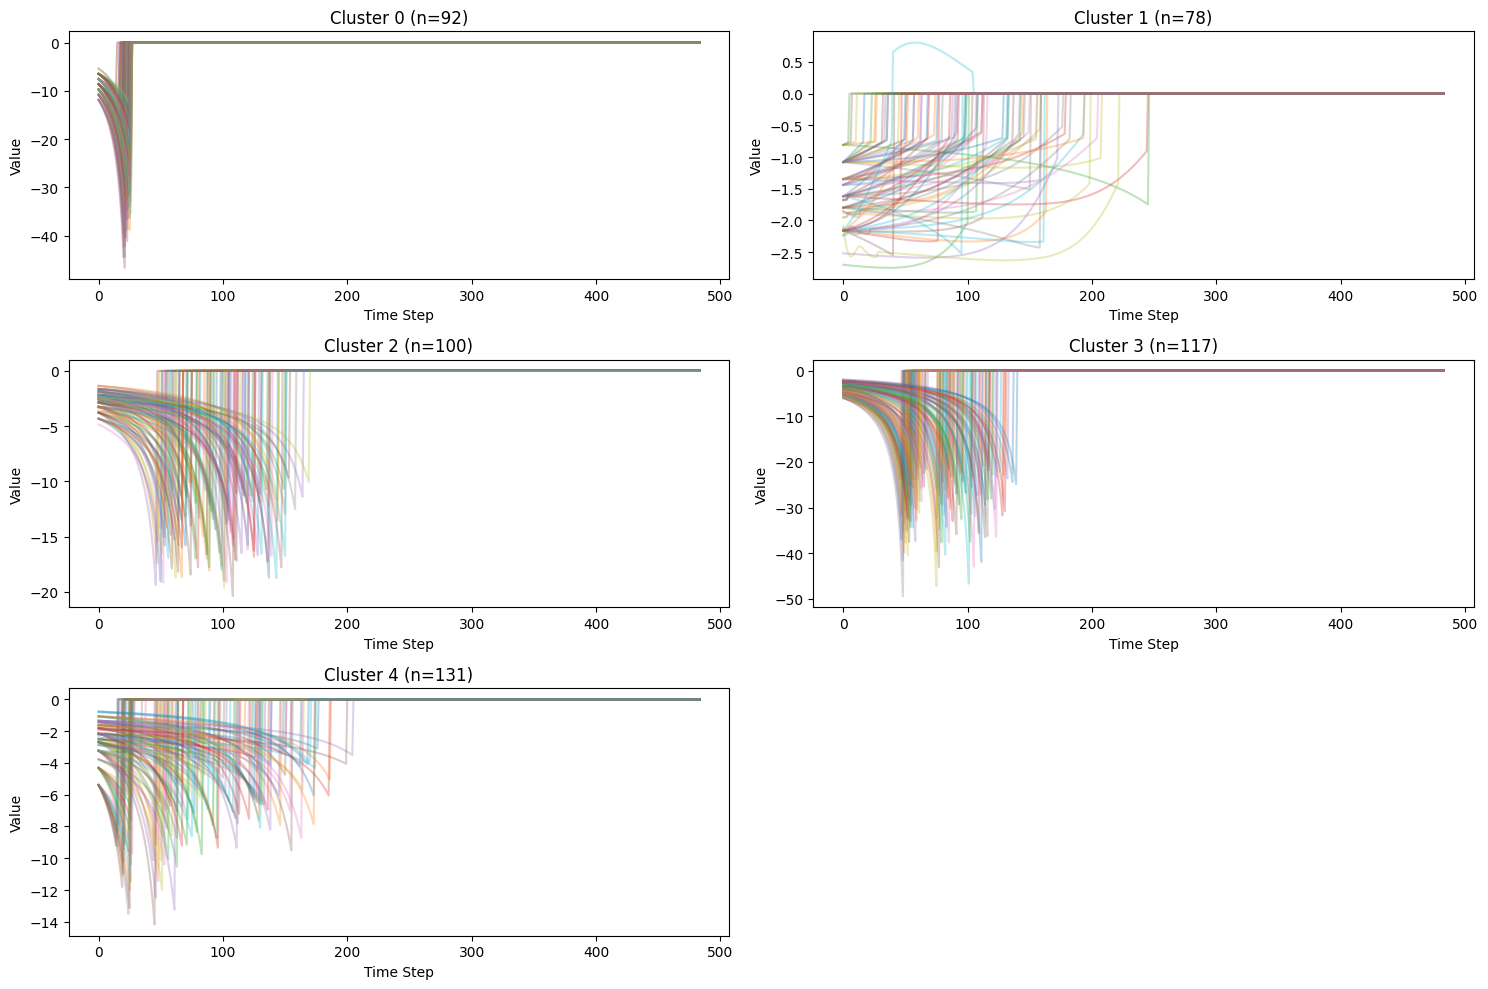

In [8]:
import matplotlib.pyplot as plt

num_clusters = len(np.unique(labels))
plt.figure(figsize=(15, 10))

for cluster in range(num_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    plt.subplot((num_clusters + 1)//2, 2, cluster + 1)

    for idx in cluster_indices:
        plt.plot(X[idx], alpha=0.3)  # plot each time series in this cluster

    plt.title(f'Cluster {cluster} (n={len(cluster_indices)})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [9]:
np.set_printoptions(threshold=np.inf)  # disable truncation
print(labels)

[4 4 1 1 4 4 1 1 4 4 4 1 4 4 4 4 0 4 4 4 0 4 2 2 0 4 1 1 0 4 4 1 0 4 4 4 0
 4 4 4 0 4 2 2 0 4 2 2 0 4 4 1 0 4 4 4 0 2 2 4 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 4 1 0 2 2 4 0 2 2 2 0 3 2 2 0 3 3 2 0 3 3 3 0 2 2 4 0 3 2 2 0 3 3 2 0 3 3
 3 0 3 3 3 0 3 3 3 0 3 2 2 0 3 3 2 0 3 3 3 0 3 3 3 0 3 3 3 0 3 3 3 0 3 3 2
 0 3 3 3 0 3 3 3 0 3 3 3 0 3 3 3 0 3 3 3 4 1 1 1 4 1 1 1 4 4 1 1 4 4 4 1 4
 4 4 4 4 4 4 4 4 4 1 1 4 4 1 1 4 4 4 1 4 4 4 4 4 4 4 4 4 2 2 2 0 4 1 1 0 4
 4 1 0 2 4 4 0 2 2 4 0 2 2 2 0 2 2 2 0 4 4 1 0 4 4 1 0 2 2 4 0 2 2 2 0 3 2
 2 0 3 3 3 0 2 4 1 0 2 2 4 0 3 2 2 0 3 3 2 0 3 3 3 0 3 3 3 0 3 2 4 0 3 2 2
 0 3 3 2 0 3 3 3 0 3 3 3 0 3 3 3 0 3 2 2 0 3 3 2 0 3 3 3 0 3 3 3 0 3 3 3 0
 3 3 3 4 1 1 1 4 1 1 1 4 1 1 1 4 1 1 1 4 4 4 1 4 4 4 4 4 1 1 1 4 1 1 1 4 4
 1 1 4 4 4 1 4 4 4 4 4 4 4 4 4 1 1 1 4 4 1 1 4 4 1 1 4 4 4 4 4 2 2 4 4 2 2
 2 0 4 1 1 0 4 1 1 0 2 4 1 0 2 2 4 0 2 2 2 0 2 2 2 0 2 1 1 0 2 4 1 0 2 2 4
 0 2 2 2 0 3 2 2 0 3 3 3 0 2 4 1 0 2 2 4 0 3 2 2 0 3 3 2 0 3 3 3 0 3 3 3 0
 3 2 1 0 3 2 2 0 3 3 2 0 

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


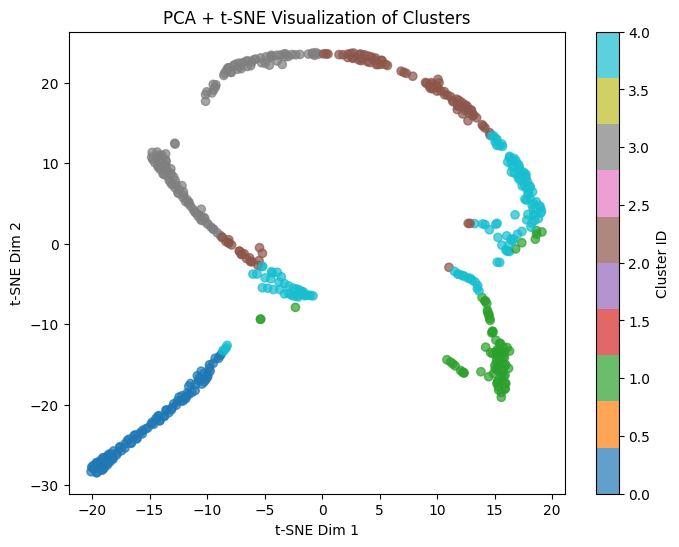

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Step 1: Reduce dimensionality with PCA first (e.g., 64D → 20D)
pca = PCA(n_components=20, random_state=0)
embeddings_pca = pca.fit_transform(embeddings)

# Step 2: Apply t-SNE on PCA-reduced embeddings
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Step 3: Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,   # cluster/class labels
    cmap="tab10",
    alpha=0.7
)
plt.title("PCA + t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
scores = {}
for k in range(2,16):
    km = KMeans(n_clusters=k, random_state=0).fit(embeddings_scaled)
    scores[k] = silhouette_score(embeddings_scaled, km.labels_)
print(scores)


{2: np.float32(0.41820338), 3: np.float32(0.4710016), 4: np.float32(0.45057762), 5: np.float32(0.3636093), 6: np.float32(0.36147377), 7: np.float32(0.3757575), 8: np.float32(0.37204728), 9: np.float32(0.3735219), 10: np.float32(0.369967), 11: np.float32(0.37131444), 12: np.float32(0.36740524), 13: np.float32(0.36781356), 14: np.float32(0.37107965), 15: np.float32(0.37008697)}
